![Banner](./docs/banner.png)

# Visão Computacional: Problemas de Detecção e Reconhecimento de Faces

In [4]:
%pip install -q retina-face deepface scikit-learn pandas matplotlib seaborn opencv-python tf-keras tensorrt pillow tqdm datasets ultralytics

DEPRECATION: Loading egg at /root/anaconda3/envs/lapixdl/lib/python3.11/site-packages/paddleseg-0.0.0.dev0-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Informações

Autores:
* Israel Efraim de Oliveira (israolive.cs@outlook.com);
* Caio César Sabino Soares;
* Gilberto Perez da Silva Junior;
* Lucas Beiler;

**Versão do Python**: 3.11.10  
**Dependências**: requirements.txt

## Introdução

A Tecnologia de Reconhecimento Facial (TRF) tem se destacado como um campo em rápida evolução dentro da Inteligência Artificial (IA), impulsionada por avanços contínuos em Machine Learning (ML) e Deep Learning (DL), e adotada amplamente em aplicações ao redor do mundo (Zafeiriou, 2015).

Definida como a capacidade de identificar ou verificar uma pessoa a partir de imagens digitais ou vídeos em tempo real, a TRF envolve a detecção e o reconhecimento facial sob condições frequentemente desafiadoras, como baixa iluminação, oclusões parciais e variações de pose, o que torna a escolha adequada de técnicas e recursos um aspecto crucial para seu desempenho.

Uma visão bastante consolidada na área de reconhecimento facial aponta que os pipelines (fluxos, sistemas) costumam seguir um encadeamento composto por quatro etapas principais: **detecção**, **alinhamento**, **representação** e **verificação**. Esse fluxo organiza o processamento da imagem para que cada etapa entregue informações mais refinadas ao próximo.

O processo começa pela **detecção**, cujo objetivo é **localizar rostos na imagem**. Detectores incluem tanto métodos clássicos quanto modelos baseados em redes neurais profundas, que além de identificar a região da face, também são capazes de extrair pontos de referência (como os olhos), fundamentais para o alinhamento. A etapa de **alinhamento** garante que todas as imagens entrem no restante da pipeline em uma configuração geométrica consistente, reduzindo variações indesejadas.

Com a face devidamente processada, empregam-se métodos de **representação**, que é o núcleo de um pipeline de reconhecimento. Nessa etapa, o rosto é transformado em um **vetor numérico** (_embeddings_) que sintetiza características discriminativas da pessoa. Modelos do estado da arte, em geral baseados em redes neurais convolucionais, são amplamente utilizados para esse fim, e incluem: FaceNet, VGG-Face, ArcFace, DeepFace, OpenFace, entre outros.

Após a extração dos embeddings, a etapa de **verificação** compara vetores de duas faces (comparação 1:1) para estimar o quão semelhantes eles são. Essa comparação é feita por meio do **cálculo de distâncias ou similaridades** entre os embeddings, utilizando métricas como Euclidiana, Euclidiana normalizada ou cosseno. A escolha da métrica define como a proximidade entre dois vetores será interpretada dentro do sistema. Se a distância ou similaridade estiver dentro de um **limiar**, assume-se que as duas faces pertencem à mesma pessoa.

Em pipelines cujo objetivo é saber a _quem_ uma face pertence (comparação 1:N), o cálculo de distância é aplicado entre os embeddings de uma face de referência (quem se deseja identificar) com um banco de dados vetorial, que armazena os embeddings das faces conhecidas. A face de referência será identificada com a identidade que teve a menor distância (ou maior similaridade) e que passou o teste do limiar.

A imagem abaixo exemplifica um pipeline completo de reconhecimento facial. A ilustração das convoluções na etapa de representação foi adaptado de Taigman (2014).

![Pipeline](./docs/pipeline.png)

In [24]:
# Definições de constantes

DETECTOR_BACKEND = "retinaface"
EMBEDDING_MODEL = "ArcFace"
MODEL_THRESHOLD = 0.68

GALLERY_PATH = "gallery.pkl"
HISTOGRAM_NAME = "data/histograma.png"

## Imports e Utilidades

In [39]:
import random
import math
import cv2
import pickle
import numpy as np
import pandas as pd
from deepface import DeepFace                 # Utilizar modelos de detecção e representação
from sklearn.datasets import fetch_lfw_people # Baixar dataset LFW

# Utilidades
import matplotlib.pyplot as plt
import seaborn as sns                         # Plots e imagens
from collections import defaultdict           # Agrupamento de identidades no banco de reconhecimento
from tqdm import tqdm                         # Demonstrar progresso


def read_img(image_path: str):
    """
    Lê uma imagem do caminho especificado e converte de BGR para RGB.
    """
    return cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)


def show_img(img, title="Image"):
    """
    Exibe uma imagem qualquer.
    """
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()


def show_face_detection(face_path, aligned_face, confidence=None, title=""):
    """
    Exibe a imagem original e a face alinhada lado a lado.
    """
    face = read_img(face_path)
    plt.figure(figsize=(10, 4))

    # Imagem original
    plt.subplot(1, 2, 1)
    plt.imshow(face)
    plt.title(f"{title} - Original")
    plt.axis("off")

    # Face alinhada + confiança
    plt.subplot(1, 2, 2)
    if confidence is not None:
        plt.title(f"{title} - Face Alinhada\nConfiança: {confidence:.4f}")
    else:
        plt.title(f"{title} - Face Alinhada")

    plt.imshow(aligned_face)
    plt.axis("off")
    plt.show()


def print_lfw_random_sample(images, targets, target_names):
    idxs = np.random.choice(len(images), size=30, replace=False)

    # Plotar 30 imagens, 5 por linha
    plt.figure(figsize=(15, 10))
    
    for i, idx in enumerate(idxs):
        plt.subplot(6, 5, i + 1)  # 6 linhas, 5 colunas
        img = images[idx]
        plt.imshow(img)
        plt.axis("off")
        person_name = target_names[targets[idx]]
        plt.title(person_name, fontsize=8)
    
    plt.tight_layout()
    plt.show()


def show_search_results(
    probe: dict,
    probe_img: np.ndarray,
    results: list[dict],
    images,
    top_k: int,
    threshold: float = MODEL_THRESHOLD
):
    fig, axes = plt.subplots(2, top_k, figsize=(4 * top_k, 6))

    # Linha 1: probe
    axes[0, 0].imshow(probe_img)
    axes[0, 0].set_title(f"Probe\n{probe['name']}")
    axes[0, 0].axis("off")
    for c in range(1, top_k):
        axes[0, c].axis("off")

    # Linha 2: resultados
    for idx, res in enumerate(results):
        img = images[res["id"]]
        color = "green" if res["distance"] <= threshold else "red"

        axes[1, idx].imshow(img)
        axes[1, idx].set_title(f"{res['name']}\nd={res['distance']:.3f}", color=color)
        axes[1, idx].axis("off")

    for empty in range(len(results), top_k):
        axes[1, empty].axis("off")

    plt.tight_layout()
    plt.show()

## Detecção de Face

O primeiro passo de qualquer sistema de reconhecimento facial é **localizar onde estão os rostos na imagem**. Essa etapa, chamada **detecção**, busca identificar regiões que realmente contenham uma face, mesmo em cenários com iluminação difícil, múltiplas pessoas ou poses variadas.  

### Localização da Face

#### Detectores clássicos

##### Viola-Jones

Usa pequenas diferenças de intensidade entre regiões da face (as chamadas características _Haar_). Ele escaneava a imagem com janelas de tamanhos diferentes, rejeitando áreas que não pareciam um rosto. Foi o primeiro detector rápido o suficiente para rodar em tempo real, mas funcionava melhor apenas para rostos frontais e iluminados.

##### Histogram of Gradients (HOG)

Em vez de trabalhar com brilho, ele analisa a direção dos contornos e bordas. Combinado com um classificador simples (ex: _SVMs_), oferecia maior robustez, mas ainda dependia do processo lento de deslizar uma janela por toda a imagem.

#### Detectores com Deep Learning

##### MTCNN

Combina três redes em cascata. A primeira localiza possíveis regiões de rosto; as seguintes filtram falsos positivos e refinam a posição da caixa, entregando também pontos de referência importantes, como olhos e boca. Ele é bem mais confiável que as técnicas clássicas, mas ainda exige múltiplos redimensionamentos da imagem para encontrar rostos grandes e pequenos.

##### RetinaFace

Diferente dos modelos anteriores, ele não varre a imagem várias vezes: processa tudo em um único passo e usa _anchors_, caixas pré-definidas distribuídas na própria rede. O modelo apenas ajusta essas caixas para caber nos rostos detectados, tornando o processo mais rápido e robusto, inclusive para rostos pequenos, inclinados ou parcialmente cobertos. Além disso, ele já retorna landmarks com alta precisão.

### Alinhamento

Depois de detectar a face, ela raramente está perfeitamente posicionada: os olhos podem estar inclinados, a cabeça pode estar levemente virada ou mais próxima da câmera. Essas **variações atrapalham a extração das características** que serão usadas no reconhecimento.

O **alinhamento corrige essa geometria**, criando uma versão padronizada da face. A forma mais simples (e usada neste trabalho) é **ajustar a imagem para que a linha dos olhos fique horizontal**, reduzindo variações de rotação.

Para isso, detectores modernos fornecem alguns pontos de referência: os _landmarks_. O conjunto mais usado é o de 5 pontos: dois olhos, nariz e cantos da boca. Esses cinco pontos permitem alinhar, centralizar e escalar a face de forma confiável, garantindo que diferentes imagens entrem no sistema sempre em uma configuração semelhante.

Modelos mais complexos podem prever dezenas de pontos (como 68 _landmarks_), o que permite alinhamentos mais detalhados. Esses modelos são úteis em tarefas como análise de expressões, reconstrução 3D ou quando a pose do rosto é mais extrema.

In [4]:
def retinaface_detect(image: str | np.ndarray) -> dict | None:
    faces = DeepFace.extract_faces(image, detector_backend=DETECTOR_BACKEND)
    
    if len(faces) == 0:
        print("Nenhuma face detectada.")
        return None

    # Retorna a primeira face
    face = faces[0]
    # a Face tem
    # {
    #   "face": <img>,
    #   "facial_area": {x, y, w, h, left_eye, right_eye},
    #   "score": <confidence>,
    #
    
    return {
        "face": face["face"],
        "landmarks": face["facial_area"],
        "confidence": face["confidence"],
    }


#### Demonstração

O código a seguir carrega as imagens de duas faces (ambas de Leonardo DiCaprio, em diferentes fases da vida), realiza a detecção da face e faz o alinhamento e enquadramento.

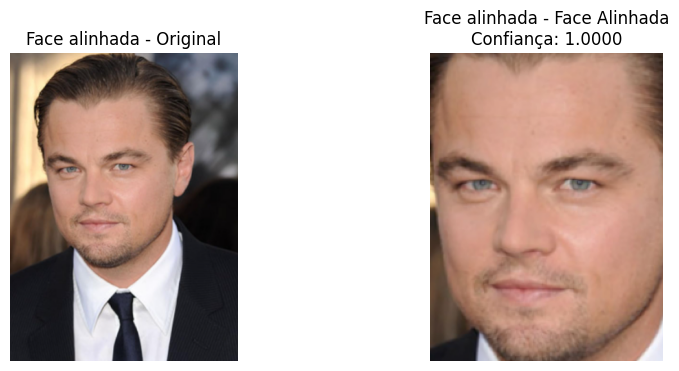

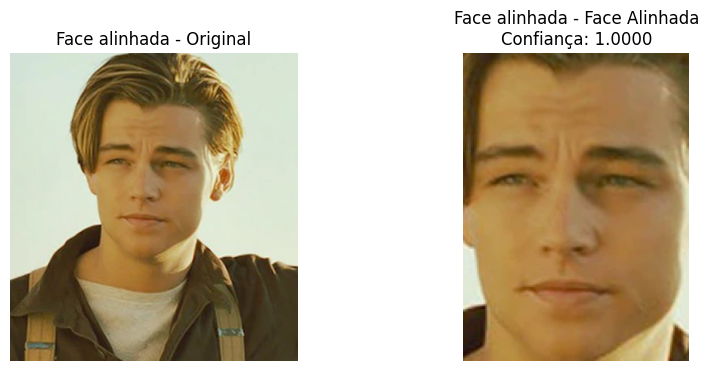

In [12]:
face_a_path = "data/dicaprio_a.png"
face_b_path = "data/dicaprio_b.png"

face_a_raw = read_img(face_a_path)
face_b_raw = read_img(face_b_path)

face_a = retinaface_detect(face_a_path)
face_b = retinaface_detect(face_b_path)

show_face_detection(face_a_path, face_a["face"], face_a["confidence"], title="Face alinhada")
show_face_detection(face_b_path, face_b["face"], face_b["confidence"], title="Face alinhada")

## Reconhecimento

### Representação Facial (_Embeddings_)

O reconhecimento facial moderno depende da capacidade de transformar uma imagem alinhada em um **vetor numérico compacto**, como um embedding de 128 ou 512 dimensões (este trabalho utiliza 512 dimensões). Esse vetor funciona como uma _assinatura_ da identidade: quanto **menor** a distância entre dois vetores, **mais semelhantes** são as faces; quanto **maior**, mais diferentes elas são.

Redes neurais profundas aprendem essa transformação ao observar muitas imagens de muitas pessoas, descobrindo automaticamente padrões que distinguem uma identidade da outra: textura da pele, formato do nariz, proporções, geometria das sobrancelhas etc. O objetivo é organizar todos os **vetores** dentro de um **espaço geométrico** onde **similaridade visual** corresponde a **proximidade numérica**.

![Exemplo embedding](./docs/cosseno.png)

### Aprendizado (_Metric Learning_)

Treinar apenas com Softmax tradicional não funciona bem para reconhecimento aberto (pessoas fora do treinamento), porque ele cria limites de classificação, não um espaço métrico discriminativo. Por isso, técnicas de **Metric Learning** dominam o reconhecimento facial.

#### _Triplet Loss_

A Triplet Loss ensina a rede usando três imagens:

* **A**: uma imagem de referência da pessoa
* **P**: outra imagem da mesma pessoa
* **N**: imagem de outra pessoa

A regra é simples:
$\text{dist}(A, P) + \alpha < \text{dist}(A, N)$

Ela força embeddings da **mesma identidade a se aproximarem**, e de **identidades diferentes a se afastarem**.
O problema é que essa técnica depende de selecionar “triplets difíceis” para gerar aprendizado útil; isso torna o treinamento instável e caro.

### _ArcFace_ (_Additive Angular Margin_)

ArcFace, que é o modelo estado da arte, resolve essa limitação substituindo a lógica de triplets por uma margem angular fixa aplicada diretamente no espaço esférico dos embeddings.
Com todos os vetores normalizados, a rede aprende que o **ângulo representa similaridade**. O ArcFace adiciona um margem (m) ao ângulo da classe correta, obrigando o modelo a produzir embeddings extremamente compactos para cada pessoa, com separação angular consistente entre identidades.

In [5]:
def embed(face, model_name: str = EMBEDDING_MODEL) -> list[float]:
    embedding_objs = DeepFace.represent(img_path=face, model_name=model_name, detector_backend=DETECTOR_BACKEND)
    return embedding_objs[0]["embedding"]


def debug_embedding(embeddings: list[float]) -> None:
    print(f"Modelo: {EMBEDDING_MODEL}")
    print(f"Dimensões: {len(embeddings)}")
    print(f"Primeiros 5 componentes: {embeddings[:5]}")

#### Demonstração



Nessa demonstração, calculam-se os **vetores das faces A e B**. As dimensões dos vetores (que devem ser a mesma) são exibidos, bem como os primeiros cinco componentes de cada vetor.

In [15]:
# Calcular vetores
face_a_vector = embed(face_a_path)
face_b_vector = embed(face_b_path)

# Depurar
debug_embedding(face_a_vector)
debug_embedding(face_b_vector)

Modelo: ArcFace
Dimensões: 512
Primeiros 5 componentes: [-0.2851991057395935, 0.030191827565431595, -0.131717711687088, 0.12609407305717468, 0.018713997676968575]
Modelo: ArcFace
Dimensões: 512
Primeiros 5 componentes: [-0.2384372055530548, -0.37307295203208923, 0.09881456941366196, -0.026606986299157143, 0.23642797768115997]


### Verificação 1:1

Na verificação, a pergunta é: **“Essas duas faces são da mesma pessoa?”**

Com dois embeddings (A) e (B), calcula-se a distância (coseno ou L2). Se essa distância for **menor que um limiar**, o sistema aceita a correspondência.

Exemplo comum em ArcFace (cosine distance): **Threshold ≈ 0.68**

Esse valor não é universal, deve ser ajustado conforme o compromisso desejado entre:

* **False Accept Rate (FAR)**: aceitar pessoas erradas;
* **False Reject Rate (FRR)**: rejeitar a pessoa correta.

Diminuir o limiar torna o sistema mais rígido: **reduz FAR**, mas **aumenta FRR**.  
Aumentar o limiar torna o sistema mais permissivo: **reduz FRR**, mas **aumenta FAR**.

In [6]:
def cosine_distance(vec_a: list[float], vec_b: list[float]) -> float:
    """
    Calcula a distância cosseno entre dois vetores de características.
    """
    source = np.array(vec_a)
    test = np.array(vec_b)
    dot_product = np.dot(source, test)
    source_norm = np.linalg.norm(source)
    test_norm = np.linalg.norm(test)

    return 1 - dot_product / (source_norm * test_norm)


def verify(vec_a: list[float], vec_b: list[float]) -> tuple[bool, float]:
    """
    Retorna uma flag de verificação e a distância obtida entre dois vetores.
    Se a distância está dentro do limiar definido, a flag retorna `True`,
    indicando que os dois vetores pertencem à mesma pessoa.
    """
    distance = cosine_distance(vec_a, vec_b)
    verified = distance <= MODEL_THRESHOLD

    return verified, distance

#### Demonstração

A seguir, realiza-se a detecção e extração dos vetores de características (embeddings) de uma pessoa diferente (Brad Pitt), a fim de ter uma **comparação negativa**.

In [17]:
face_c_path = "data/pitt_a.png"
face_c = retinaface_detect(face_c_path)
face_c_vector = embed(face_c_path)
debug_embedding(face_c_vector)

Modelo: ArcFace
Dimensões: 512
Primeiros 5 componentes: [-0.000561560969799757, 9.942986071109772e-05, 0.08024007827043533, -0.37599068880081177, 0.16651000082492828]


Então, verifica-se a **distância das faces A e B**, bem como **A e C**, para validar se os pares pertencem à mesma pessoa.

Na verificação A-B, retorna-se `True`, que confirma que as faces pertencem à mesma pessoa, pois a distância obtida é menor do que o limiar definido (no início deste notebook).  
Já na comparação A-C, a distância é levemente superior, então se retorna `False`.

In [18]:
match_ab = verify(face_a_vector, face_b_vector)
match_ac = verify(face_a_vector, face_c_vector)

print("Verificação faces A-B: {}, {} (Cosseno)".format(*match_ab))
print("Verificação faces A-C: {}, {} (Cosseno)".format(*match_ac))

Verificação faces A-B: True, 0.42965776970794334 (Cosseno)
Verificação faces A-C: False, 0.6940854705005246 (Cosseno)


### Verificação 1:N

Na Verificação 1:N (identificação), a pergunta muda: **“Quem é essa pessoa?”**

O embedding de entrada é comparado contra **todos** os vetores de um banco de dados vetorial ((N) registros). Busca-se o mais parecido, mas só há _match_ se a distância também for menor que um limiar rigoroso.

O desafio é o crescimento explosivo de **falsos positivos**: mesmo uma taxa mínima de erro, quando multiplicada por milhões de comparações, produz correspondências incorretas.
Por isso, o limiar em 1:N é geralmente **muito mais restritivo** do que em 1:1, e sistemas grandes inevitavelmente aumentam a taxa de “não encontrados”.

#### Criação de uma Galeria (Banco de Dados vetorial em memória)

Neste trabalho, utiliza-se do dataset _Labeled Faces in the Wild_ (LFW) como banco de dados de imagens, carregando apenas pessoas que possuem ao menos duas imagens.

O dataset é dividido por identidade:
* Para cada pessoa, uma imagem é escolhida aleatoriamente para compor a **galeria** (banco de identidade, referências).
* Todas as demais tornam-se **probes** (amostras) para validação posterior.

As funções abaixo se dedicam à receber o dataset LFW e criar um banco de dados de teste em memória (bem como salvá-lo num arquivo Pickle) com os vetores gerados a partir do modelo ArcFace.

In [7]:
def embed_array(img_array: np.ndarray, model_name: str = EMBEDDING_MODEL) -> list[float]:
    """
    Gera um vetor de embedding diretamente a partir de um array float64 ou uint8 (formato do LFW).
    """
    # Se vier float [0..1], converte para uint8
    img_uint8 = img_array if img_array.dtype == np.uint8 else (img_array * 255).astype(np.uint8)

    embedding_objs = DeepFace.represent(
        img_path=img_uint8,
        model_name=model_name,
        detector_backend=DETECTOR_BACKEND,
        enforce_detection=False,
    )
    
    return embedding_objs[0]["embedding"]


def group_by_identity(images, targets, target_names):
    """
    Agrupa as imagens de acordo com o nome (target_names).
    """
    grouped = defaultdict(list)
    for idx, _ in enumerate(images):
        person_name = target_names[targets[idx]]
        grouped[person_name].append(idx)
    return grouped


def split_gallery_probe(grouped):
    """
    Separa uma imagem por pessoa para o banco de imagens e adiciona o resto para amostragem (probes).
    """
    gallery_indices = []
    probe_indices = []

    for person, idx_list in grouped.items():
        if len(idx_list) == 1:
            # só 1 foto: fica só na gallery ou skip
            gallery_indices.append(idx_list[0])
        else:
            random.shuffle(idx_list)
            gallery_indices.append(idx_list[0])      # referência
            probe_indices.extend(idx_list[1:])       # probes

    return gallery_indices, probe_indices


def build_gallery_from_indices(images, target_names, targets, gallery_indices, save_path=GALLERY_PATH):
    """
    Gera os vetores para todas as imagens no banco de dados (galeria).
    """
    gallery = []

    for idx in tqdm(gallery_indices, desc="Gerando vetores das faces"):
        vec = embed_array(images[idx])
        gallery.append({
            "id": idx,
            "name": target_names[targets[idx]],
            "vector": vec
        })

    print("Salvando vetores.")
    with open(save_path, "wb") as f:
        pickle.dump(gallery, f)

    print(f"Gallery criada com {len(gallery)} identidades.")
    return gallery


def build_probe_set(images, target_names, targets, probe_indices):
    """
    Formata uma base para validação.
    """
    probes = []

    for idx in tqdm(probe_indices, desc="Gerando base de validação"):
        probes.append({
            "id": idx,
            "name": target_names[targets[idx]],
            "image": images[idx]
        })

    print(f"Probe set criado com {len(probes)} imagens.")
    return probes

#### Busca em uma galeria de imagens

In [8]:
def search_identity(probe_vector: list[float], gallery, top_k=1) -> list[dict] | dict:
    """
    Busca os *top_k* vetores mais similares ao vetor de entrada.
    Retorna uma lista se top_k > 1, ou um dict se top_k = 1.
    """
    results = []
    for entry in gallery:
        dist = cosine_distance(probe_vector, entry["vector"])
        results.append({
            "name": entry["name"],
            "id": entry["id"],
            "distance": dist
        })
    results = sorted(results, key=lambda x: x["distance"])
    return results[0] if top_k == 1 else results[:top_k]

#### Carregamento do Dataset

In [9]:
# Carregar Dataset LFW (Labeled Faces in the Wild). Isso demora bastante na primeira execução.
print("Carregando Dataset...")
lfw = fetch_lfw_people(min_faces_per_person=2, resize=1.0, color=True)

images = lfw.images
targets = lfw.target
target_names = lfw.target_names

print("Dataset carregado com {} imagens de {} identidades.".format(len(images), len(target_names)))

Carregando Dataset...
Dataset carregado com 9164 imagens de 1680 identidades.


In [11]:
grouped = group_by_identity(images, targets, target_names)
gallery_indices, probe_indices = split_gallery_probe(grouped)

In [13]:
gallery = build_gallery_from_indices(
    images, target_names, targets,
    gallery_indices,
    save_path="gallery.pkl"
)

Gerando vetores das faces: 100%|██████████| 1680/1680 [07:53<00:00,  3.54it/s]

Salvando vetores.
Gallery criada com 1680 identidades.


In [15]:
probes = build_probe_set(images, target_names, targets, probe_indices)

Gerando base de validação: 100%|██████████| 7484/7484 [00:00<00:00, 909649.10it/s]

Probe set criado com 7484 imagens.


##### Demonstração

Abaixo, imprime-se uma amostra do dataset LFW e, em seguida, elenca-se uma imagem aleatória para recuperação das três faces do banco de identidade mais similares.

In [ ]:
print_lfw_random_sample(images, targets, target_names)

![Amostra LFW](./docs/lfw.png)

In [ ]:
top_k = 5
threshold = 0.4 # pode ser MODEL_THRESHOLD também

probe = random.choice(probes)
probe_img = probe["image"]
probe_vec = embed_array(probe_img)

# Busca top_k mais similares
results = search_identity(probe_vec, gallery, top_k=top_k)
if top_k == 1:
    results = [results]  # normaliza para lista

show_search_results(probe, probe_img, results, images, top_k, threshold)

![Exemplo de busca](./docs/search.png)

### Validação

A validação é feita simulando um cenário **open-set 1:N** (em que nem todas as imagens estão no banco de identidades), onde o sistema deve identificar quem é a pessoa em cada imagem de teste (probe).

Cada probe é convertido em embedding e comparado com todos os vetores da galeria usando **distância do cosseno**, retornando o candidato mais similar (Rank-1). Com esse resultado, o sistema registra se a identificação foi correta e armazena distâncias de pares genuínos e impostores para análise posterior. Além da acurácia Rank-1, o método aplica um **limiar (threshold)** sobre a distância para medir _True Accept_, _False Accept_ e _False Reject_, permitindo avaliar o comportamento do sistema como verificador open-set: quanto o limiar deixa o sistema mais permissivo (aumentando falsas aceitações) ou mais rigoroso (aumentando falsas rejeições).

Assim, cada probe contribui simultaneamente para as métricas de identificação (1:N) e para a análise de decisão binária (aceitar/rejeitar) baseada em distância.


In [25]:
THRESHOLD = MODEL_THRESHOLD
SAMPLE_NUM = 1000

# Seleciona probes aleatórios sem reposição
sample_probes = random.sample(probes, SAMPLE_NUM)

total = len(sample_probes)
correct_top1 = 0
true_accept = 0
false_reject = 0
false_accept = 0

# Listas para histograma
genuine_distances = []   # mesma pessoa
impostor_distances = []  # pessoa diferente

print("Rodando avaliação...")

for probe in tqdm(sample_probes, desc="Validando probes"):
    probe_vec = embed_array(probe["image"])
    result = search_identity(probe_vec, gallery)

    same_person = (result["name"] == probe["name"])
    dist = result["distance"]

    # Histograma
    if same_person:
        genuine_distances.append(dist)
    else:
        impostor_distances.append(dist)

    # Acurácia Rank-1
    if same_person:
        correct_top1 += 1

    # Avaliação Open-set
    if dist < THRESHOLD:
        if same_person:
            true_accept += 1
        else:
            false_accept += 1
    else:
        if same_person:
            false_reject += 1


Rodando avaliação...


Validando probes: 100%|██████████| 1000/1000 [05:29<00:00,  3.03it/s]


#### Resultados

In [ ]:
rank1 = correct_top1 / total
FAR = false_accept / total
FRR = false_reject / total
TAR = true_accept / total

print("\n===== RESULTADOS =====")
print(f"Total de probes: {total}")
print(f"Rank-1 Accuracy: {rank1:.4f}")
print(f"True Accept Rate (TAR): {TAR:.4f}")
print(f"False Accept Rate (FAR): {FAR:.4f}")
print(f"False Reject Rate (FRR): {FRR:.4f}")
print("======================")

In [ ]:
sns.set_style("white")

plt.figure(figsize=(12, 7))

# Histogramas
plt.hist(genuine_distances, bins=30, alpha=0.55, label="Genuínas", color="#4A90E2", edgecolor="none")
plt.hist(impostor_distances, bins=30, alpha=0.55, label="Impostoras", color="#E67E22", edgecolor="none")

# Linha do limiar
plt.axvline(THRESHOLD, linestyle="--", linewidth=3, color="black", label=f"Limiar = {THRESHOLD}")

# Labels e título
plt.xlabel("Distância (cosine-distance)", fontsize=20)
plt.ylabel("Frequência", fontsize=20)
plt.title("Distribuição das Distâncias: Genuínas vs Impostoras",
          fontsize=28, fontweight="bold", pad=20)
plt.xticks(fontsize=14, color="#666666")
plt.yticks(fontsize=14, color="#666666")

plt.grid(alpha=0.12)

# Spines suavizados
for spine in plt.gca().spines.values():
    spine.set_color("#888888")
    spine.set_linewidth(1.2)

# Legenda
plt.legend(fontsize=16, frameon=False)

plt.tight_layout()
plt.savefig(HISTOGRAM_NAME, dpi=900, bbox_inches="tight")
plt.show()

#### Resultados Obtidos:

| Métrica                  | Valor   |
|--------------------------|---------|
| Total de amostras        | 1000    |
| Precisão Rank-1          | 83.5%   |
| True Accept Rate (TAR)   | 83.5%   |
| False Accept Rate (FAR)  | 16.4%   |
| False Reject Rate (FRR)  | 0%      |

![Histograma](./data/histograma.png)

## Referências

1. Zafeiriou S., Zhang C., Zhang Z. A survey on face detection in the wild: Past, present and future. Comput. Vis. Image Underst. 2015;138:1–24. doi: 10.1016/j.cviu.2015.03.015.
2. S. Serengil and A. Özpınar, “A Benchmark of Facial Recognition Pipelines and Co-Usability Performances of Modules”, Bilişim Teknolojileri Dergisi, Apr. 2024
3. Y. Taigman, M. Yang, M. Ranzato, and L. Wolf, “Deep-face: Closing the gap to human-level performance in face verification”, In Proceedings of the IEEE conference on computer vision and pattern recognition, 2014.

## Apêndice

### Treinamento do Yolo

In [ ]:
import os
from pathlib import Path
from datasets import load_dataset
from PIL import Image
from tqdm import tqdm
import yaml


# CONFIGURAÇÃO INICIAL
DATASET_HUGGINGFACE_ID = "CUHK-CSE/wider_face"
YOLO_DATASET_PATH = Path("./wider_face_yolo")
YAML_CONFIG_FILE = "wider_face_config.yaml"


# FUNÇÃO DE CONVERSÃO DE FORMATO
def convert_bbox_to_yolo(img_size, bbox):
    img_width, img_height = img_size
    x_min, y_min, w, h = bbox
    
    x_center = x_min + w / 2
    y_center = y_min + h / 2
    
    x_center_norm = x_center / img_width
    y_center_norm = y_center / img_height
    width_norm = w / img_width
    height_norm = h / img_height
    
    return f"0 {x_center_norm} {y_center_norm} {width_norm} {height_norm}"


# PROCESSAMENTO DO DATASET
def prepare_dataset():
    print(f"Iniciando download do dataset: {DATASET_HUGGINGFACE_ID}")
    dataset = load_dataset(DATASET_HUGGINGFACE_ID, trust_remote_code=True)
    print("Download concluído.")
    
    splits_to_process = {'train': dataset['train'], 'validation': dataset['validation']}
    
    for split_name, split_data in splits_to_process.items():
        print(f"\nProcessando o conjunto '{split_name}'")
        
        images_dir = YOLO_DATASET_PATH / "images" / split_name
        labels_dir = YOLO_DATASET_PATH / "labels" / split_name
        
        images_dir.mkdir(parents=True, exist_ok=True)
        labels_dir.mkdir(parents=True, exist_ok=True)
        
        for i, item in enumerate(tqdm(split_data, desc=f"Salvando {split_name}")):
            image = item['image']
            faces = item['faces']
            
            image_filename = f"{split_name}_{i}.jpg"
            label_filename = f"{split_name}_{i}.txt"
            
            image.save(images_dir / image_filename)
            
            yolo_annotations = []
            if faces['bbox']:
                for bbox in faces['bbox']:
                    yolo_line = convert_bbox_to_yolo(image.size, bbox)
                    yolo_annotations.append(yolo_line)
            
            if yolo_annotations:
                with open(labels_dir / label_filename, 'w') as f:
                    f.write("\n".join(yolo_annotations))


# CRIAÇÃO DO ARQUIVO DE CONFIGURAÇÃO YAML
def create_yolo_config_file():
    print(f"\nCriando arquivo de configuração: {YAML_CONFIG_FILE}")
    
    config_data = {
        'path': str(YOLO_DATASET_PATH.absolute()),
        'train': 'images/train',
        'val': 'images/validation',
        'test': 'images/validation',
        'names': {
            0: 'face'
        }
    }
    
    with open(YAML_CONFIG_FILE, 'w') as f:
        yaml.dump(config_data, f, sort_keys=False, default_flow_style=False)
    
    print("Arquivo de configuração criado com sucesso.")


In [ ]:
prepare_dataset()
create_yolo_config_file()

print("\n" + "="*50)
print("PREPARAÇÃO CONCLUÍDA COM SUCESSO!")
print("="*50)

train_command = (
    f"yolo train "
    f"model=yolov8s.pt "
    f"data={YAML_CONFIG_FILE} "
    f"epochs=50 "
    f"imgsz=640 "
    f"batch=16 "
    f"device=0"
)

print("TREINAR YOLO (copie e cole o comando em uma célula):")
print("Observação: Você deve ter um arquivo yolov8s.pt base no diretório atual, que pode ser baixado no site da Ultralytics.")
print(f"{train_command}\n\n")

In [ ]:
%yolo train model=yolov8s.pt data=wider_face_config.yaml epochs=200 imgsz=640 batch=16 device=0

#### Resultados

##### Exemplo de Classificação

![Amostra de Classificação](./yolo/sample.jpg)

##### Treinamento e Métricas

![Métricas](./yolo/results.png)